In [1]:
import sys
import os
import keras
from keras.models import Model
from keras.callbacks import EarlyStopping
import math
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Activation
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.models import Sequential
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# Download the data - google colab issue
!git clone https://github.com/argonne-lcf/AI4ScienceTutorial 

fatal: destination path 'AI4ScienceTutorial' already exists and is not an empty directory.


# Data preprocessing 

In [3]:
def process_data(train, test, lags):
    """Process data
    Reshape and split train\test data.

    # Arguments
        train: String, name of .csv train file.
        test: String, name of .csv test file.
        lags: integer, time lag.
    # Returns
        X_train: ndarray.
        y_train: ndarray.
        X_test: ndarray.
        y_test: ndarray.
        scaler: StandardScaler.
    """
    attr = 'Lane 1 Flow (Veh/5 Minutes)'
    df1 = pd.read_csv(train, encoding='utf-8').fillna(0)
    df2 = pd.read_csv(test, encoding='utf-8').fillna(0)

    # scaler = StandardScaler().fit(df1[attr].values)
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df1[attr].values.reshape(-1, 1))
    flow1 = scaler.transform(df1[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    flow2 = scaler.transform(df2[attr].values.reshape(-1, 1)).reshape(1, -1)[0]

    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    return X_train, y_train, X_test, y_test, scaler

# Sequential learning
We will utilize two popular frameworks for learning data which are distinctly _non i.i.d_

<img src="imgs/RNN_Apps.png" width="800">

## Recurrent neural networks (RNNs)

<img src="imgs/RNN_Maths.png" width="600">

## Long short-term memory networks (LSTMs)
<img src="imgs/LSTM_Maths.png" width="800">

# Model building 

In [4]:
"""
Train the NN model.
"""
def get_rnn(units):
    """RNN(Recurrent Neural Network)
    Build RNN Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(SimpleRNN(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(SimpleRNN(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model

def get_lstm(units):
    """LSTM(Long Short-Term Memory)
    Build LSTM Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(LSTM(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(LSTM(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model

# Model training

In [5]:
def train_model(model, X_train, y_train, name, config):
    """train
    train a single model.

    # Arguments
        model: Model, NN model to train.
        X_train: ndarray(number, lags), Input data for train.
        y_train: ndarray(number, ), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])
    model.summary()
    # early = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
    hist = model.fit(
        X_train, y_train,
        batch_size=config["batch"],
        epochs=config["epochs"],
        validation_split=0.05)

    folder = 'model/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    model.save('model/' + name + '.h5')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('model/' + name + ' loss.csv', encoding='utf-8', index=False)

    return hist


In [6]:
lag = 12
config = {"batch": 256, "epochs": 10}
file1 = 'AI4ScienceTutorial/sess5_timeseries/data/train.csv'
file2 = 'AI4ScienceTutorial/sess5_timeseries/data/test.csv'
X_train, y_train, _, _, _ = process_data(file1, file2, lag)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 12, 64)            4224      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 7375 samples, validate on 

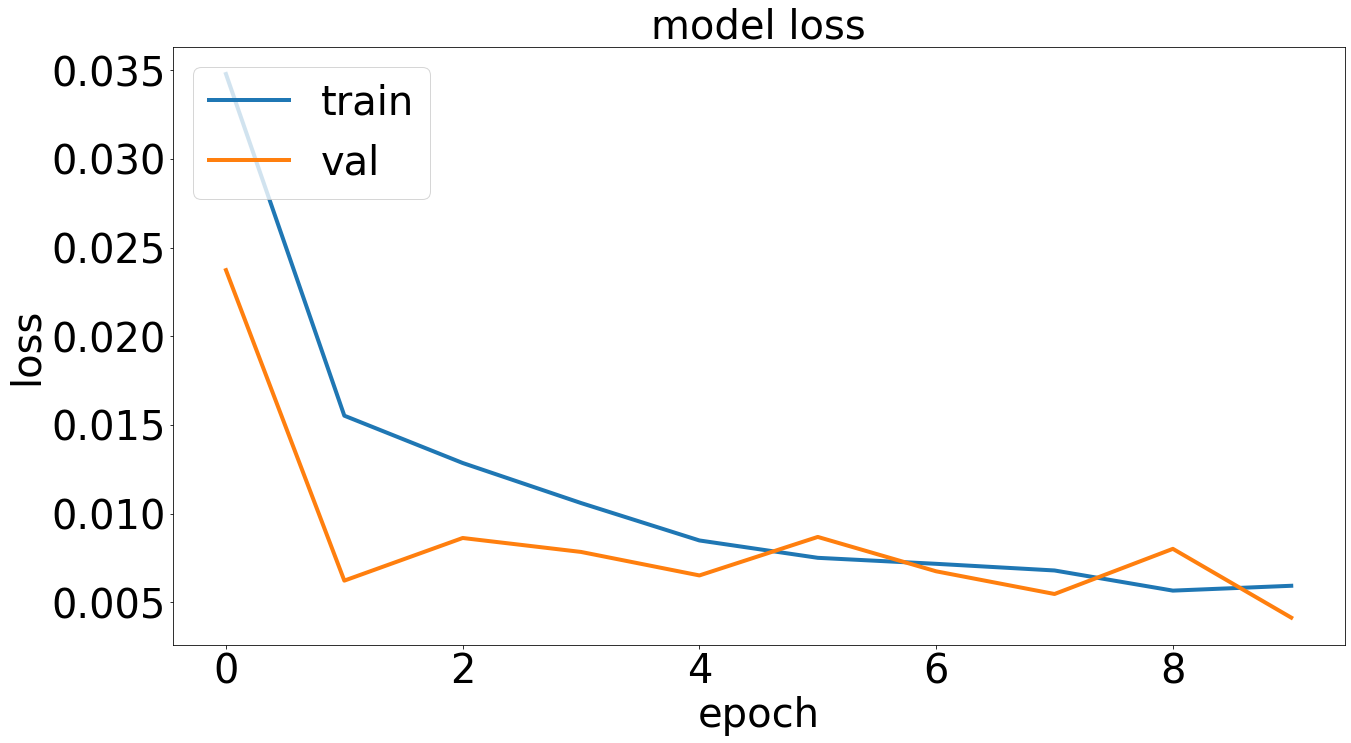

In [7]:
m = get_rnn([12, 64, 64, 1])
history = train_model(m, X_train, y_train, 'rnn', config)

plt.figure(figsize=(21, 11))
plt.plot(history.history['loss'], linewidth=4)
plt.plot(history.history['val_loss'], linewidth=4)
plt.title('model loss', fontsize=40)
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.ylabel('loss', fontsize=40)
plt.xlabel('epoch', fontsize=40)
plt.legend(['train', 'val'], loc='upper left', fontsize=40)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train on 7375 samples, validate on 389 samples
Epoch 1/10
7375/7375 [==============================] - 2s 256us/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 2/10
7375/7375 [==============================] - 1

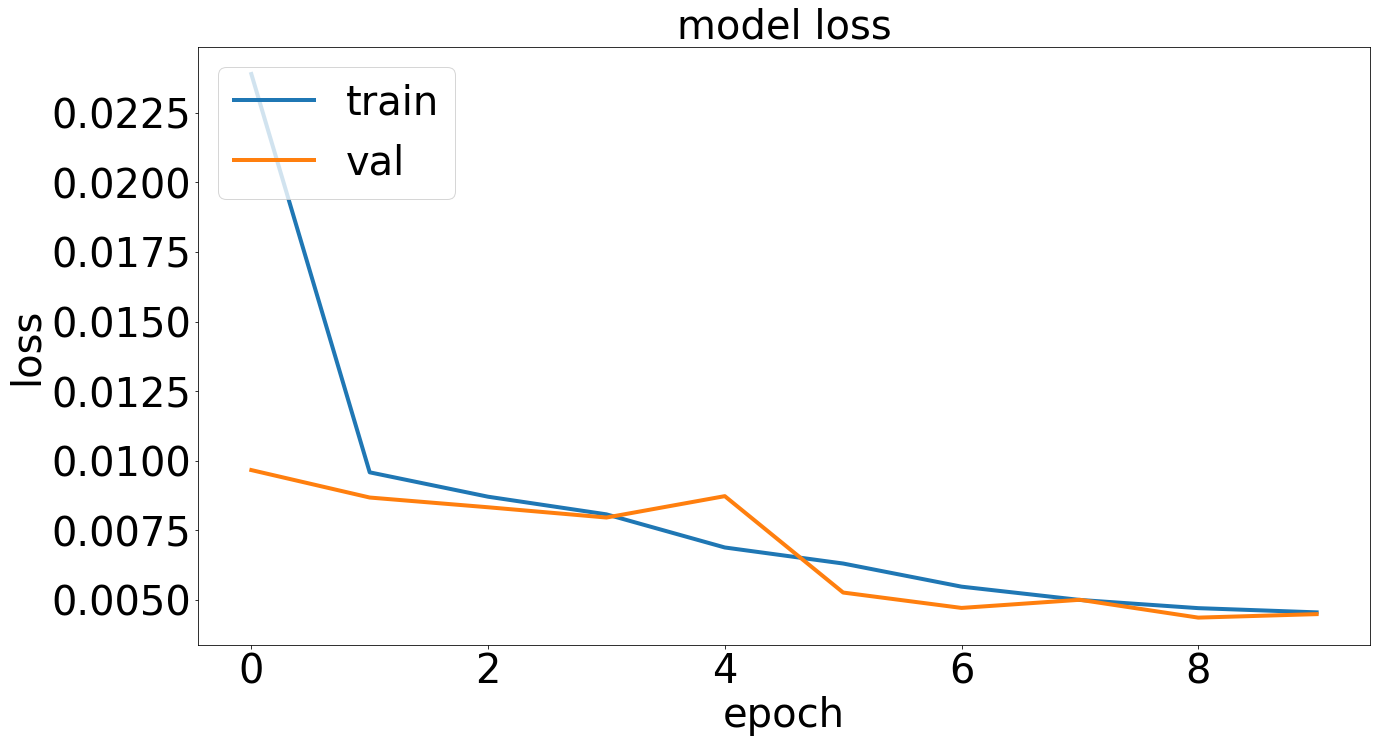

In [8]:
m = get_lstm([12, 64, 64, 1])
history = train_model(m, X_train, y_train, 'lstm', config)

plt.figure(figsize=(21, 11))
plt.plot(history.history['loss'], linewidth=4)
plt.plot(history.history['val_loss'], linewidth=4)
plt.title('model loss', fontsize=40)
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.ylabel('loss', fontsize=40)
plt.xlabel('epoch', fontsize=40)
plt.legend(['train', 'val'], loc='upper left', fontsize=40)
plt.show()

# Prediction 

In [9]:
"""
Traffic Flow Prediction with Neural Networks(SAEs、LSTM、GRU).
"""
def MAPE(y_true, y_pred):
    """Mean Absolute Percentage Error
    Calculate the mape.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    # Returns
        mape: Double, result data for train.
    """

    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape


def eva_regress(y_true, y_pred):
    """Evaluation
    evaluate the predicted result.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    """

    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)


def plot_results(y_true, y_preds, names):
    """Plot
    Plot the true data and predicted data.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
        names: List, Method names.
    """
    d = '2016-3-4 00:00'
    x = pd.date_range(d, periods=288, freq='5min')

    fig = plt.figure(figsize=(21, 11))
    ax = fig.add_subplot(111)

    ax.plot(x, y_true, label='True Data', linewidth=4)
    for name, y_pred in zip(names, y_preds):
        ax.plot(x, y_pred, label=name, linewidth=4)

    plt.legend(prop={'size': 40})
    plt.yticks(fontsize=40)
    plt.xticks(fontsize=40)
    plt.grid(True)
    plt.xlabel('Time of Day', fontsize=50)
    plt.ylabel('Flow', fontsize=50)

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    plt.show()


explained_variance_score:0.927588
mape:51.426960%
mae:9.805114
mse:146.304479
rmse:12.095639
r2:0.909935
explained_variance_score:0.913290
mape:21.730898%
mae:8.898825
mse:152.474542
rmse:12.348058
r2:0.906137


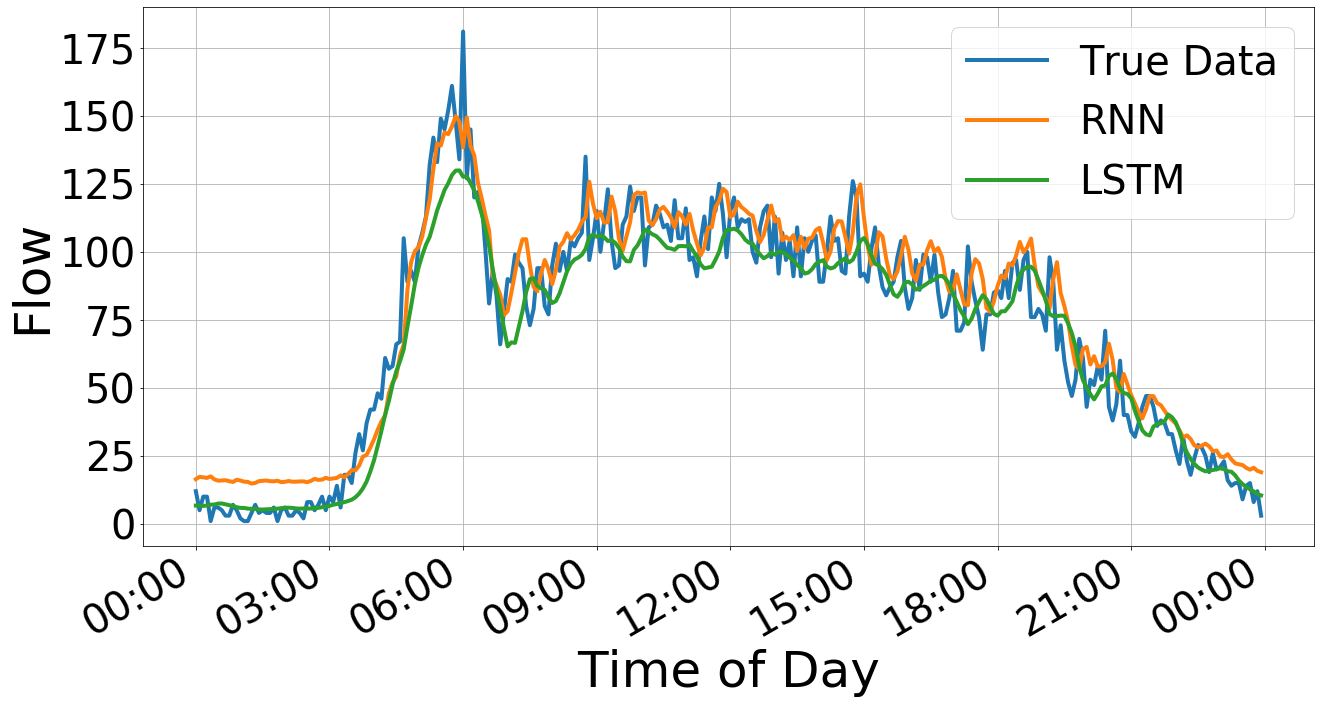

In [10]:
rnn = load_model('model/rnn.h5')
lstm = load_model('model/lstm.h5')
models = [rnn,lstm]
names = ['RNN','LSTM']

lag = 12
file1 = 'AI4ScienceTutorial/sess5_timeseries/data/train.csv'
file2 = 'AI4ScienceTutorial/sess5_timeseries/data/test.csv'
_, _, X_test, y_test, scaler = process_data(file1, file2, lag)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

y_preds = []
for name, model in zip(names, models):
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
    y_preds.append(predicted[:288])
    eva_regress(y_test, predicted)

plot_results(y_test[: 288], y_preds, names)